# Telecom Churn Case study

### Group Members:
- __Tejas Wagh(Group facilitator)__
- __Pawan Tejwani__
- __Dr.Sandeep Patil __
- __Abhishek Singh __



#### We have represented case study in the following format:
- Data Cleaning and Formatting
- EDA
- PCA and logistic regression for predicting customers who are going to churn.
- Tree models for identifying important indicators in predicting customers who are going to churn.
- Final report

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn import preprocessing
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


/home/tejas/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
telecom = pd.read_csv('telecom_churn_data.csv')

In [3]:
telecom.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [4]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [5]:
print(telecom['total_rech_amt_6'].isnull().sum(),telecom['total_rech_amt_7'].isnull().sum(), telecom['total_rech_data_6'].isnull().sum(), telecom['total_rech_data_7'].isnull().sum())

0 0 74846 74428


In [6]:
#### Imputing missing values

telecom['total_rech_data_6'].fillna(0, inplace=True)
telecom['total_rech_data_7'].fillna(0, inplace=True)
telecom['total_rech_data_8'].fillna(0, inplace=True)
telecom['total_rech_data_9'].fillna(0, inplace=True)
telecom['av_rech_amt_data_6'].fillna(0, inplace=True)
telecom['av_rech_amt_data_7'].fillna(0, inplace=True)
telecom['av_rech_amt_data_8'].fillna(0, inplace=True)
telecom['av_rech_amt_data_9'].fillna(0, inplace=True)
telecom['max_rech_data_6'].fillna(0, inplace=True)
telecom['max_rech_data_7'].fillna(0, inplace=True)
telecom['max_rech_data_8'].fillna(0, inplace=True)
telecom['max_rech_data_9'].fillna(0, inplace=True)


telecom['night_pck_user_6'].fillna(-1, inplace=True)
telecom['night_pck_user_7'].fillna(-1, inplace=True)
telecom['night_pck_user_8'].fillna(-1, inplace=True)
telecom['night_pck_user_9'].fillna(-1, inplace=True)
telecom['fb_user_6'].fillna(-1, inplace=True)
telecom['fb_user_7'].fillna(-1, inplace=True)
telecom['fb_user_8'].fillna(-1, inplace=True)
telecom['fb_user_9'].fillna(-1, inplace=True)

In [7]:
telecom['total_rech_amt_data_6'] = telecom['total_rech_data_6'] * telecom['av_rech_amt_data_6']
telecom['total_rech_amt_data_7'] = telecom['total_rech_data_7'] * telecom['av_rech_amt_data_7']
telecom['total_rech_amt_data_8'] = telecom['total_rech_data_8'] * telecom['av_rech_amt_data_8']
telecom['total_rech_amt_data_9'] = telecom['total_rech_data_9'] * telecom['av_rech_amt_data_9']

In [8]:
#As per problem statement creating a column of average recharge amount of first two months
telecom['avg_rech_amt'] = ((telecom['total_rech_amt_6'] + telecom['total_rech_amt_data_6']) + (telecom['total_rech_amt_7'] + telecom['total_rech_amt_data_7']))/2

##### As per problem statement creating dataframe which has only customers with average recharge amount more than or equal to 70th percentile of average recharge amount 


In [9]:
Q = telecom.avg_rech_amt.quantile(0.7)

In [10]:
telecom = telecom[telecom.avg_rech_amt >= Q]

In [11]:
telecom.shape

(30001, 231)

In [12]:
telecom['churn'] = np.where(((telecom['total_ic_mou_9']==0) & (telecom['total_og_mou_9']==0)) & ((telecom['vol_2g_mb_9']==0) & (telecom['vol_3g_mb_9']==0)),1,0)

In [13]:
telecom['churn'].value_counts()

0    27560
1     2441
Name: churn, dtype: int64

In [14]:
#dropping columns with '_9' at the end
new_col = [c for c in telecom.columns if c[-2:] != '_9']
telecom = telecom[new_col]

In [15]:
# Checking percentage missing values in each columns
round(100*(telecom.isnull().sum()/len(telecom.index)))

mobile_number             0.0
circle_id                 0.0
loc_og_t2o_mou            1.0
std_og_t2o_mou            1.0
loc_ic_t2o_mou            1.0
last_date_of_month_6      0.0
last_date_of_month_7      0.0
last_date_of_month_8      1.0
arpu_6                    0.0
arpu_7                    0.0
arpu_8                    0.0
onnet_mou_6               2.0
onnet_mou_7               2.0
onnet_mou_8               4.0
offnet_mou_6              2.0
offnet_mou_7              2.0
offnet_mou_8              4.0
roam_ic_mou_6             2.0
roam_ic_mou_7             2.0
roam_ic_mou_8             4.0
roam_og_mou_6             2.0
roam_og_mou_7             2.0
roam_og_mou_8             4.0
loc_og_t2t_mou_6          2.0
loc_og_t2t_mou_7          2.0
loc_og_t2t_mou_8          4.0
loc_og_t2m_mou_6          2.0
loc_og_t2m_mou_7          2.0
loc_og_t2m_mou_8          4.0
loc_og_t2f_mou_6          2.0
                         ... 
arpu_2g_7                43.0
arpu_2g_8                47.0
night_pck_

In [16]:
max(round(100*(telecom.isnull().sum()/len(telecom.index))))

47.0

In [17]:
#dropping columns which have more than 50% NaN values
for cl in telecom.columns:
    if round(100*(telecom[cl].isnull().sum()/len(telecom[cl].index)), 2) > 40:
        telecom = telecom.drop(cl, axis=1)

In [18]:
round(100*(telecom.isnull().sum()/len(telecom.index)))

mobile_number            0.0
circle_id                0.0
loc_og_t2o_mou           1.0
std_og_t2o_mou           1.0
loc_ic_t2o_mou           1.0
last_date_of_month_6     0.0
last_date_of_month_7     0.0
last_date_of_month_8     1.0
arpu_6                   0.0
arpu_7                   0.0
arpu_8                   0.0
onnet_mou_6              2.0
onnet_mou_7              2.0
onnet_mou_8              4.0
offnet_mou_6             2.0
offnet_mou_7             2.0
offnet_mou_8             4.0
roam_ic_mou_6            2.0
roam_ic_mou_7            2.0
roam_ic_mou_8            4.0
roam_og_mou_6            2.0
roam_og_mou_7            2.0
roam_og_mou_8            4.0
loc_og_t2t_mou_6         2.0
loc_og_t2t_mou_7         2.0
loc_og_t2t_mou_8         4.0
loc_og_t2m_mou_6         2.0
loc_og_t2m_mou_7         2.0
loc_og_t2m_mou_8         4.0
loc_og_t2f_mou_6         2.0
                        ... 
vol_3g_mb_7              0.0
vol_3g_mb_8              0.0
night_pck_user_6         0.0
night_pck_user

In [19]:
null_4=[]
for cl in telecom.columns:
    if 2<round(100*(telecom[cl].isnull().sum()/len(telecom[cl].index)), 2)<5 :
        null_4.append(cl)
# null_4 is the list of columns with 4% missing values 

In [20]:
null_4

['onnet_mou_8',
 'offnet_mou_8',
 'roam_ic_mou_8',
 'roam_og_mou_8',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_8',
 'loc_og_mou_8',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_8',
 'std_og_t2c_mou_8',
 'std_og_mou_8',
 'isd_og_mou_8',
 'spl_og_mou_8',
 'og_others_8',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2f_mou_8',
 'loc_ic_mou_8',
 'std_ic_t2t_mou_8',
 'std_ic_t2m_mou_8',
 'std_ic_t2f_mou_8',
 'std_ic_t2o_mou_8',
 'std_ic_mou_8',
 'spl_ic_mou_8',
 'isd_ic_mou_8',
 'ic_others_8']

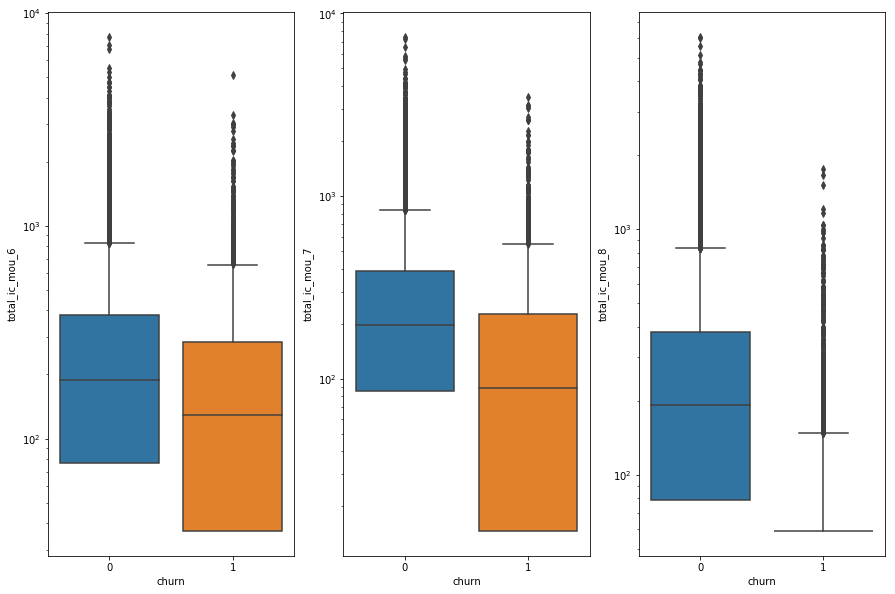

In [21]:
## Let's see minutes of usage boxplots for total_ic_mou_6
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='total_ic_mou_6', data=telecom)
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='total_ic_mou_7', data=telecom)
plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='total_ic_mou_8', data=telecom)
plt.yscale('log')


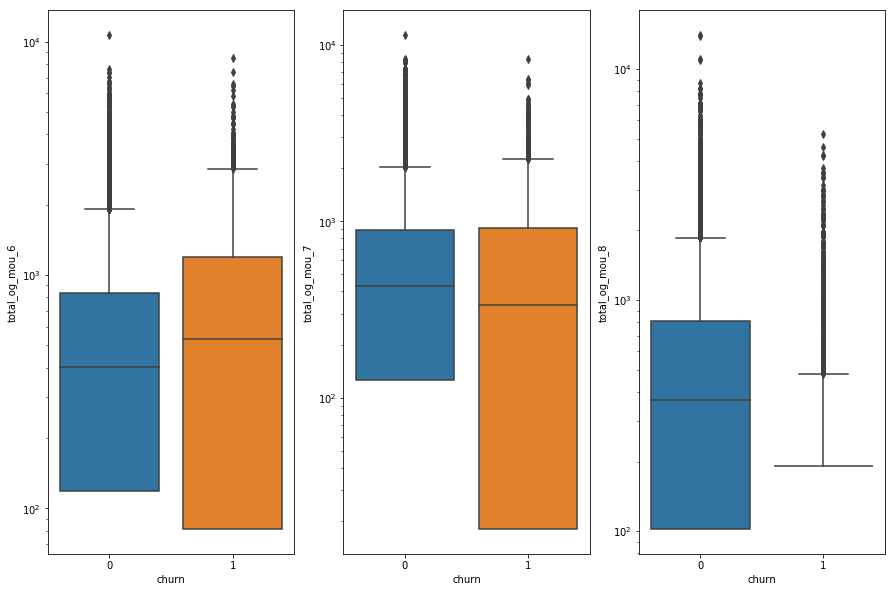

In [22]:
## Let's see minutes of usage boxplots for total_og_mou_6
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='total_og_mou_6', data=telecom)
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='total_og_mou_7', data=telecom)
plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='total_og_mou_8', data=telecom)
plt.yscale('log')


- All the columns with 4 percent missing values are from 8th month(_8 at the end). 
- From the boxplot above those who are going to churn in 9th month, there is significant drop in total_ic_mou_8 and total_og_mou_8.Which implies customers have stopped getting any type of incoming or outgoing calls.
- Therefore in the columns with _mou_8 at the end we can impute 0 for null values.

In [23]:
for nl in null_4:
    telecom[nl].fillna(0, inplace=True)

In [24]:
max(round(100*(telecom.isnull().sum()/len(telecom.index)), 2))

1.9399999999999999

In [25]:
#Dropping rows with missing values
telecom= telecom.dropna(axis=0)

In [26]:
# All of the object datatype columns are of dates. We are dropping those here
obj_col =telecom.select_dtypes(include=['object']).columns
obj_col

Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'],
      dtype='object')

In [27]:
## Formatting columns which have date in them
for oc in obj_col:
    telecom[oc]= pd.to_datetime(telecom[oc],format = "%m/%d/%Y")
## Removing month and year and only keeping date(day of the month) as month is already captured in columns name
telecom['last_day_of_month_6'] = telecom['last_date_of_month_6'].dt.day
telecom['last_day_of_month_7'] = telecom['last_date_of_month_7'].dt.day
telecom['last_day_of_month_8'] = telecom['last_date_of_month_8'].dt.day
telecom['day_of_last_rech_6'] = telecom['date_of_last_rech_6'].dt.day
telecom['day_of_last_rech_7'] = telecom['date_of_last_rech_7'].dt.day
telecom['day_of_last_rech_8'] = telecom['date_of_last_rech_8'].dt.day

In [28]:
telecom= telecom.drop(obj_col, axis=1)

In [29]:
# creating separate dataframe for categorical variables
cat_list= ['night_pck_user_6','night_pck_user_7','night_pck_user_8','fb_user_6','fb_user_7','fb_user_8']
telecom_categorical= telecom[cat_list]
telecom_categorical.head()

,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8
7,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,-1.0,0.0,0.0,-1.0,1.0,1.0
21,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
23,-1.0,0.0,0.0,-1.0,1.0,1.0
33,1.0,1.0,0.0,1.0,1.0,1.0


In [30]:
# creating another dataframe for numerical variables
telecom_numerical = telecom.drop(cat_list, axis=1)
telecom_numerical = telecom_numerical.drop('churn', axis= 1)


In [31]:
telecom_numerical.nunique().sort_values(ascending=True)

std_ic_t2o_mou_6           1
std_og_t2c_mou_8           1
std_og_t2c_mou_7           1
std_ic_t2o_mou_7           1
std_ic_t2o_mou_8           1
last_day_of_month_7        1
last_day_of_month_6        1
std_og_t2c_mou_6           1
loc_ic_t2o_mou             1
std_og_t2o_mou             1
loc_og_t2o_mou             1
circle_id                  1
last_day_of_month_8        1
monthly_2g_6               5
monthly_2g_8               6
monthly_2g_7               6
monthly_3g_8              12
monthly_3g_6              12
monthly_3g_7              15
sachet_3g_6               25
sachet_3g_7               26
sachet_3g_8               29
day_of_last_rech_6        30
sachet_2g_6               31
day_of_last_rech_8        31
day_of_last_rech_7        31
sachet_2g_8               34
sachet_2g_7               34
total_rech_data_6         38
total_rech_data_7         42
                       ...  
loc_og_t2m_mou_8       15007
loc_ic_t2m_mou_8       15036
loc_ic_t2m_mou_6       15260
loc_og_t2m_mou

In [32]:
#To capture maximum variance let's drop the columns which have only one value in them
telecom_numerical = telecom_numerical.loc[:,telecom.apply(pd.Series.nunique) >1]

In [33]:
telecom_numerical.shape

(28667, 142)

In [34]:
numeric_col= telecom_numerical.columns

In [35]:
telecom_categorical.shape

(28667, 6)

In [36]:
main_frame = pd.concat([telecom_numerical,telecom_categorical, telecom['churn']], axis=1)
main_frame.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,day_of_last_rech_6,day_of_last_rech_7,day_of_last_rech_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8,churn
7,7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,...,27,25,26,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
8,7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,...,25,31,30,-1.0,0.0,0.0,-1.0,1.0,1.0,0
21,7002124215,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,...,30,31,31,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
23,7000887461,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,...,18,7,24,-1.0,0.0,0.0,-1.0,1.0,1.0,0
33,7000149764,977.020,2362.833,409.230,0.00,0.00,0.00,0.00,0.00,0.00,...,30,30,26,1.0,1.0,0.0,1.0,1.0,1.0,0


In [37]:
main_frame['churn'].value_counts()

0    26755
1     1912
Name: churn, dtype: int64

# EDA
#### Here we're aiming to understand behaviour and recognize pattern of churners before they churned


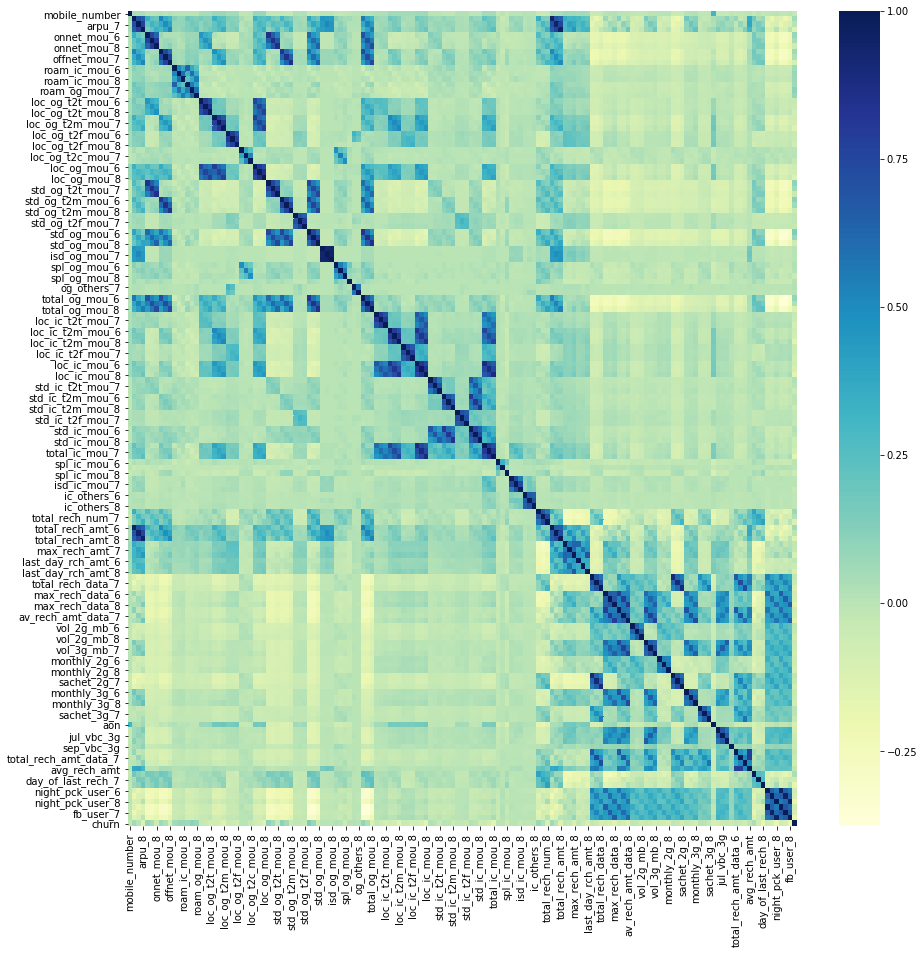

In [38]:
## Lets see the correlation matrix first

# figure size
plt.figure(figsize=(15,15))

# heatmap
sns.heatmap(main_frame.corr(), cmap="YlGnBu")
plt.show()


- Since the feature space is too large it is very difficult to analyse the correlation matrix above

### Analysis of different recharge and data usage
- Analysis of avg_rech_amt_6/7/8

In [39]:
main_frame.pivot_table(values = 'avg_rech_amt',
                      index = 'churn', 
                      aggfunc = 'mean')

,avg_rech_amt
churn,
0,1161.269935
1,1084.965609


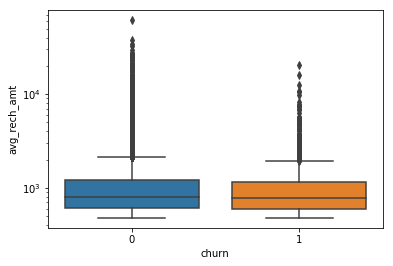

In [40]:
sns.boxplot(x='churn', y='avg_rech_amt', data=main_frame)
plt.yscale('log')

- let's analyse last_day_rch_amt6/7/8

In [41]:
main_frame.pivot_table(values = ['last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8
churn,,,
0,97.908503,100.252962,97.266380
1,92.900628,74.975941,39.241632


- There is significant drop in mean last_day_rch_amt_8 for the churners who are going to churn

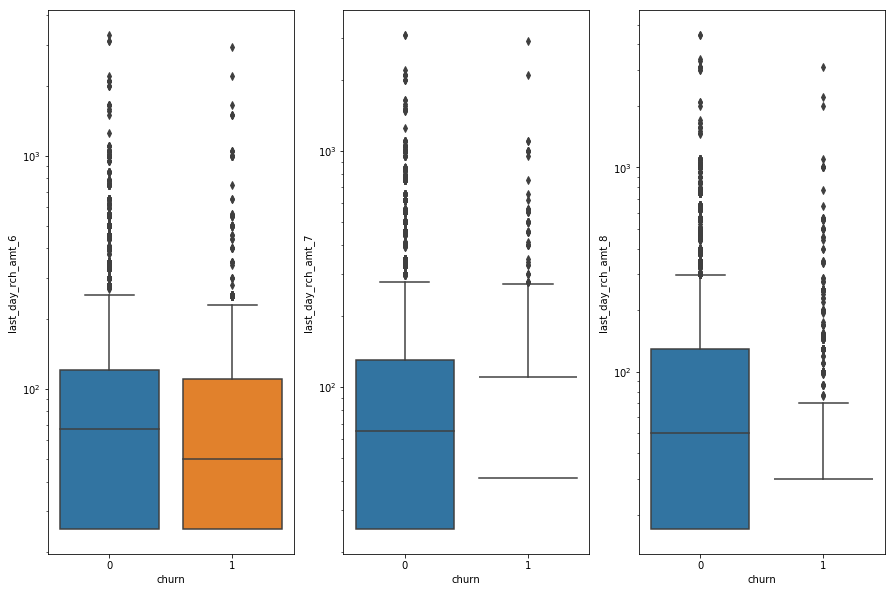

In [42]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='last_day_rch_amt_6', data=main_frame)
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='last_day_rch_amt_7', data=main_frame)
plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='last_day_rch_amt_8', data=main_frame)
plt.yscale('log')


- let's analyse __total_rch_data_6/7/8__

In [43]:
main_frame.pivot_table(values = ['total_rech_data_6','total_rech_data_7','total_rech_data_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,total_rech_data_6,total_rech_data_7,total_rech_data_8
churn,,,
0,1.683984,1.907606,1.740534
1,1.468619,1.412657,0.464435


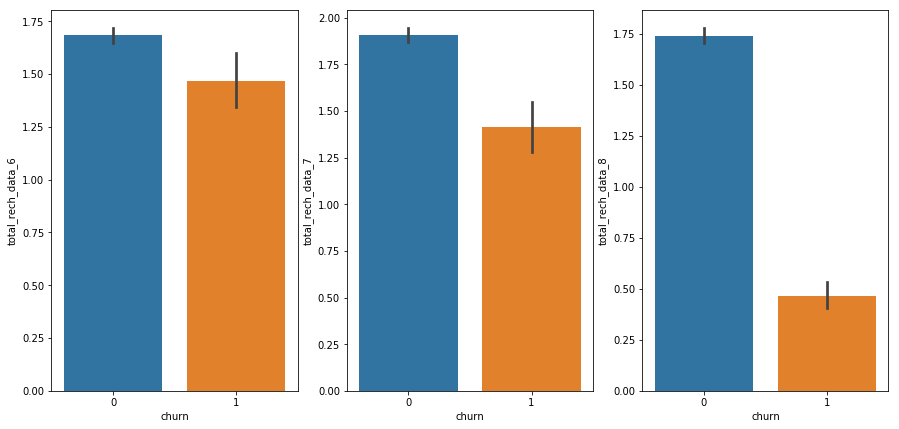

In [44]:
plt.figure(figsize=(15,7))

plt.subplot(1, 3, 1)
sns.barplot(x='churn', y='total_rech_data_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.barplot(x='churn', y='total_rech_data_7', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 3)
sns.barplot(x='churn', y='total_rech_data_8', data=main_frame)
# plt.yscale('log')

In [45]:
main_frame[['total_rech_data_6','total_rech_data_7','total_rech_data_8']].describe()

,total_rech_data_6,total_rech_data_7,total_rech_data_8
count,28667.000000,28667.000000,28667.000000
mean,1.669620,1.874594,1.655423
std,2.840402,3.108316,3.020571
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000
max,61.000000,54.000000,60.000000


- __av_rech_amt_data__ analysis 

In [46]:
main_frame.pivot_table(values = ['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8
churn,,,
0,129.783762,141.353873,128.399423
1,87.862793,80.961946,27.764555


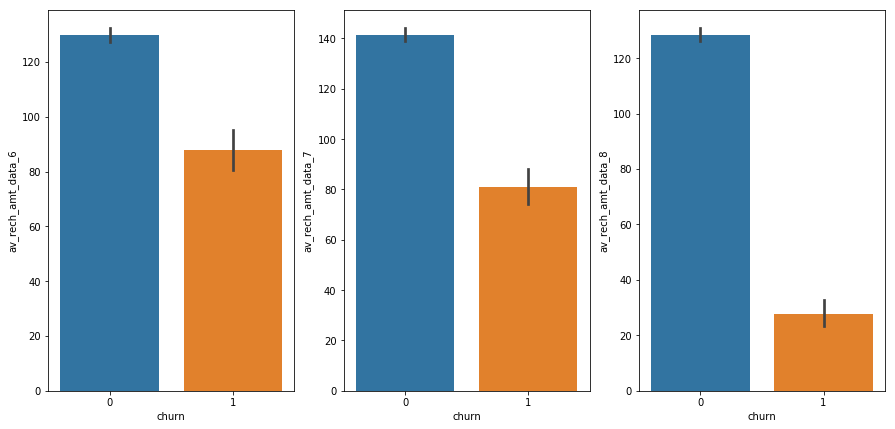

In [47]:
plt.figure(figsize=(15,7))

plt.subplot(1, 3, 1)
sns.barplot(x='churn', y='av_rech_amt_data_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.barplot(x='churn', y='av_rech_amt_data_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.barplot(x='churn', y='av_rech_amt_data_8', data=main_frame)
# plt.yscale('log')


- total rech_amt_data_6/7/8

In [48]:
main_frame.pivot_table(values = ['total_rech_amt_data_6','total_rech_amt_data_7','total_rech_amt_data_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8
churn,,,
0,456.752050,542.051359,495.770884
1,359.215178,346.448258,84.445900


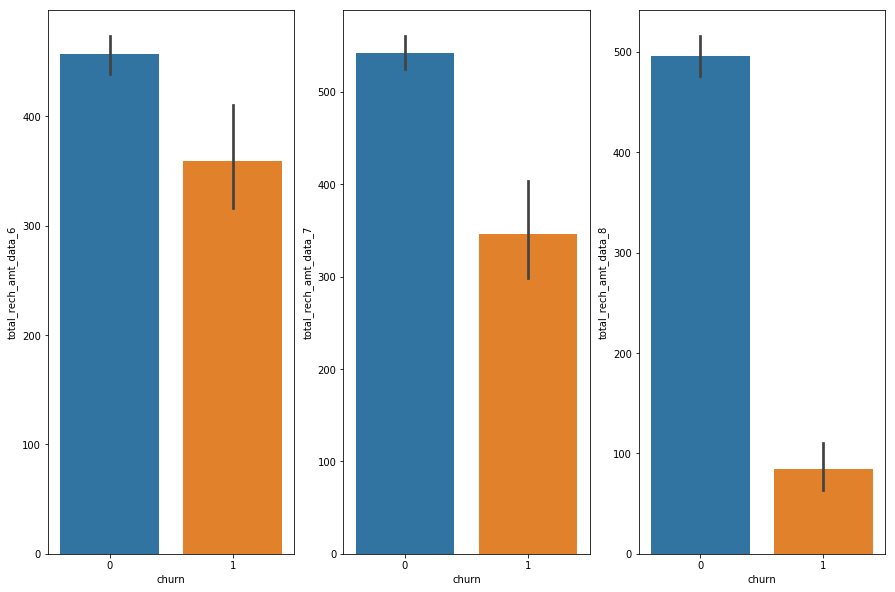

In [49]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.barplot(x='churn', y='total_rech_amt_data_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.barplot(x='churn', y='total_rech_amt_data_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.barplot(x='churn', y='total_rech_amt_data_8', data=main_frame)
# plt.yscale('log')


- __vol_3g_mb__ analysis

In [50]:
main_frame.pivot_table(values = ['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8
churn,,,
0,337.924894,371.538358,364.397041
1,211.040973,189.714759,70.255099


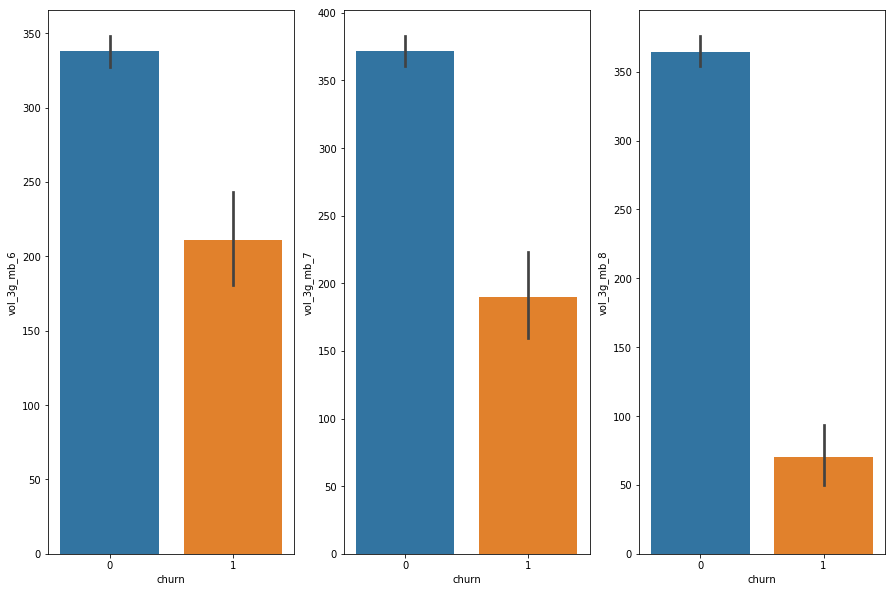

In [51]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.barplot(x='churn', y='vol_3g_mb_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.barplot(x='churn', y='vol_3g_mb_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.barplot(x='churn', y='vol_3g_mb_8', data=main_frame)
# plt.yscale('log')


- __max_rech_data_6/7/8__ analysis

In [52]:
main_frame.pivot_table(values = ['max_rech_data_6','max_rech_data_7','max_rech_data_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,max_rech_data_6,max_rech_data_7,max_rech_data_8
churn,,,
0,77.129733,79.916277,75.459428
1,49.570084,44.749477,18.237448


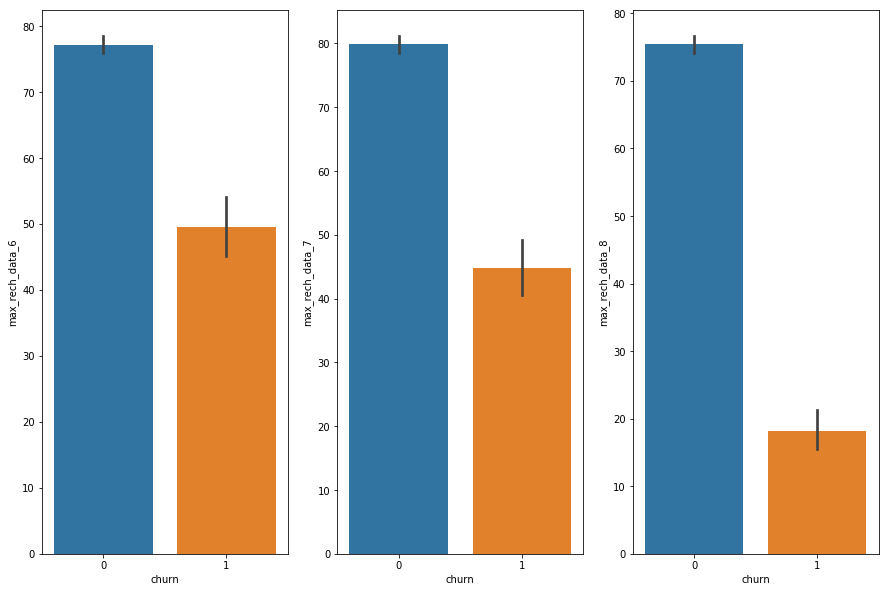

In [53]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.barplot(x='churn', y='max_rech_data_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.barplot(x='churn', y='max_rech_data_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.barplot(x='churn', y='max_rech_data_8', data=main_frame)
# plt.yscale('log')


- __max_rech_data_6/7/8__ analysis

In [54]:
main_frame.pivot_table(values = ['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8
churn,,,
0,166.202878,170.377163,167.035395
1,156.818515,153.854079,94.241632


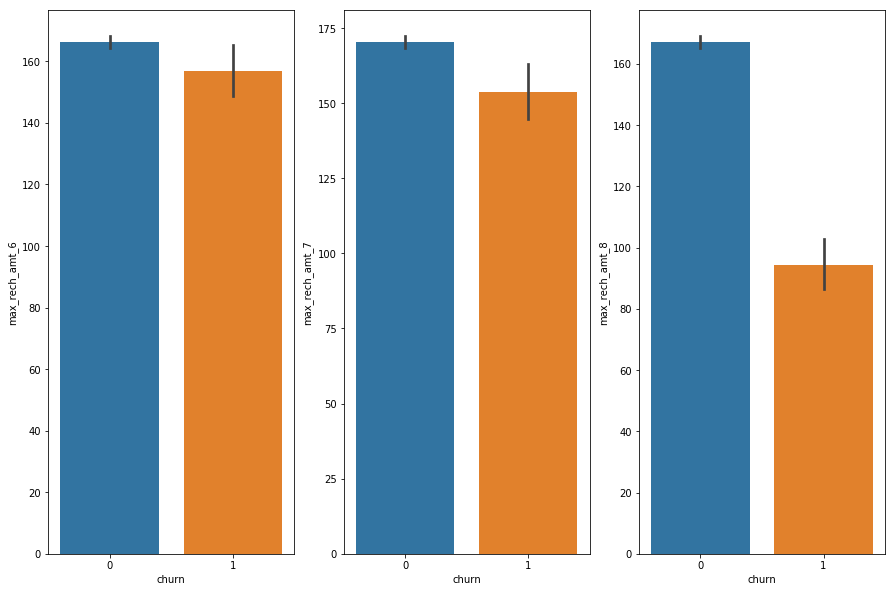

In [55]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.barplot(x='churn', y='max_rech_amt_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.barplot(x='churn', y='max_rech_amt_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.barplot(x='churn', y='max_rech_amt_8', data=main_frame)
# plt.yscale('log')


### Analysis of _Minutes of Usage_

- let's analyse __total_ic_mou_6/7/8__

In [56]:
main_frame.pivot_table(values = ['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8
churn,,,
0,301.170532,313.130757,305.171674
1,230.884074,199.434210,77.338081


- There is significant drop in mean __total_ic_mou_8__ for the churners who are going to churn

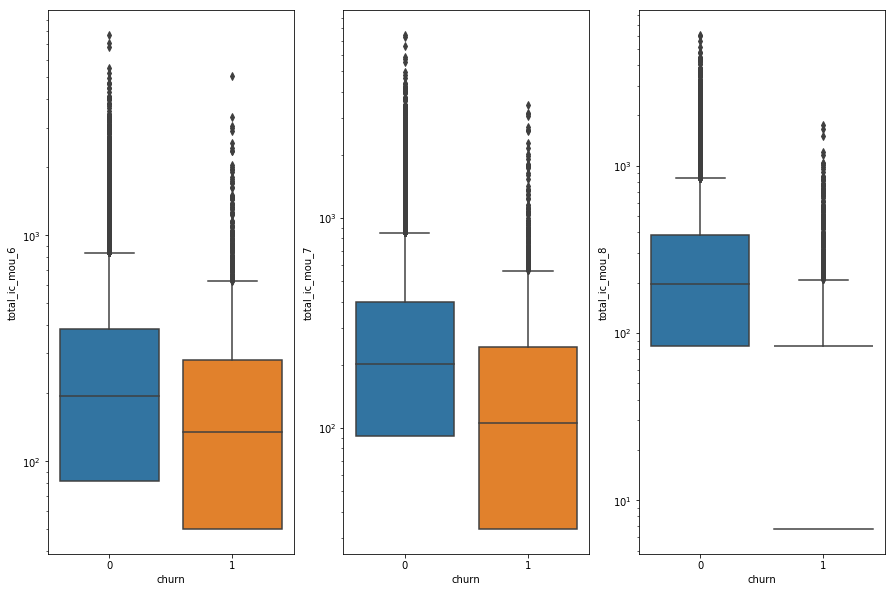

In [57]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='total_ic_mou_6', data=main_frame)
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='total_ic_mou_7', data=main_frame)
plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='total_ic_mou_8', data=main_frame)
plt.yscale('log')


- let's analyse __total_og_mou_6/7/8__

In [58]:
main_frame.pivot_table(values = ['total_og_mou_6','total_og_mou_7','total_og_mou_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,total_og_mou_6,total_og_mou_7,total_og_mou_8
churn,,,
0,604.471284,638.175186,590.961017
1,866.185021,724.674571,257.744665


- There is significant drop in mean __total_og_mou_8__ for the churners who are going to churn

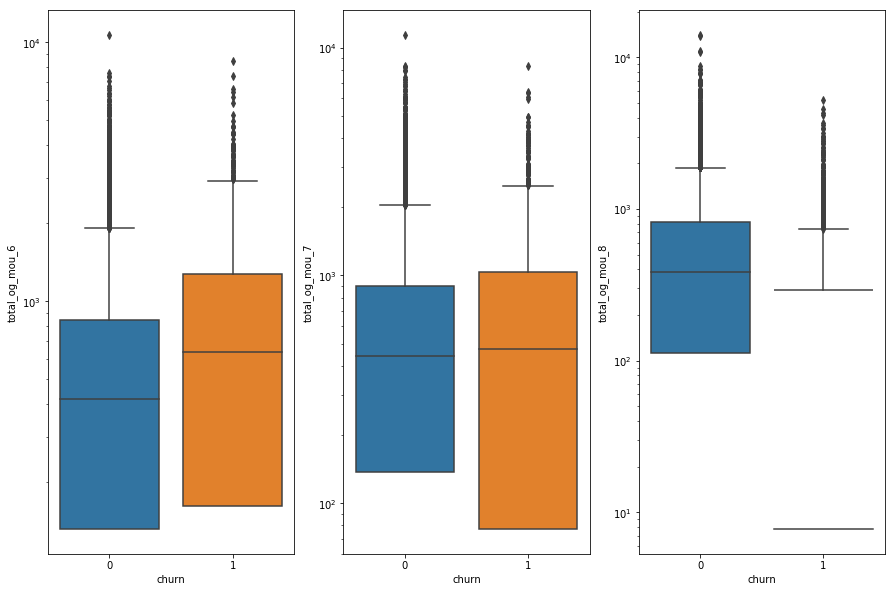

In [59]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='total_og_mou_6', data=main_frame)
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='total_og_mou_7', data=main_frame)
plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='total_og_mou_8', data=main_frame)
plt.yscale('log')


- Above we saw significant drop in total minutes of usage variable in 8th month compare to what it wqas in 6th and 7th month. 
- Let's break it down further in roaming and local minutes of usage and see what we can find:

- let's analyse __roam_og_mou_6/7/8 and roam_ic_mou_6/7/8__

In [60]:
main_frame.pivot_table(values = ['roam_og_mou_6','roam_og_mou_7','roam_og_mou_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8
churn,,,
0,24.867119,17.798751,18.149048
1,56.436736,59.986339,54.272197


In [61]:
main_frame.pivot_table(values = ['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8
churn,,,
0,15.288042,11.308593,11.438395
1,32.248468,35.051407,33.573604


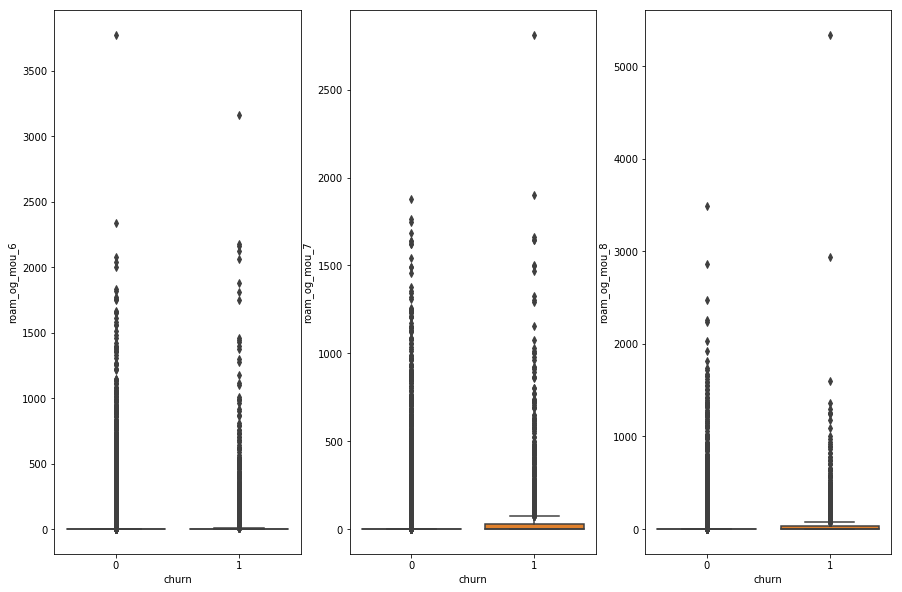

In [62]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='roam_og_mou_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='roam_og_mou_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='roam_og_mou_8', data=main_frame)
# plt.yscale('log')


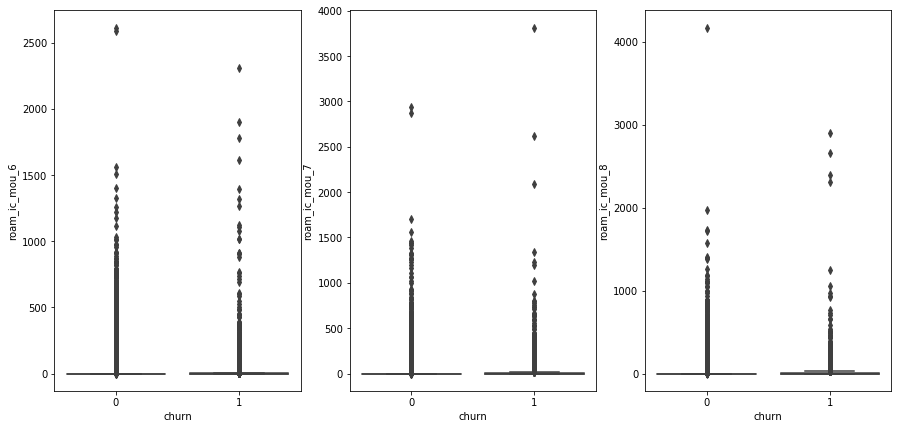

In [63]:
plt.figure(figsize=(15,7))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='roam_ic_mou_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='roam_ic_mou_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='roam_ic_mou_8', data=main_frame)
# plt.yscale('log')


- Let's see of loc_og/ic_mou explains anything

In [64]:
main_frame.pivot_table(values= ['loc_og_mou_6','loc_og_mou_7','loc_og_mou_8'],
                       index= 'churn',
                      aggfunc= 'mean')

,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8
churn,,,
0,265.231903,270.095505,256.569694
1,176.139032,149.879623,60.435455


In [65]:
main_frame.pivot_table(values= ['loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8'],
                       index= 'churn',
                      aggfunc= 'mean')

,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8
churn,,,
0,242.077600,248.908688,244.124561
1,161.448964,137.388938,54.789430


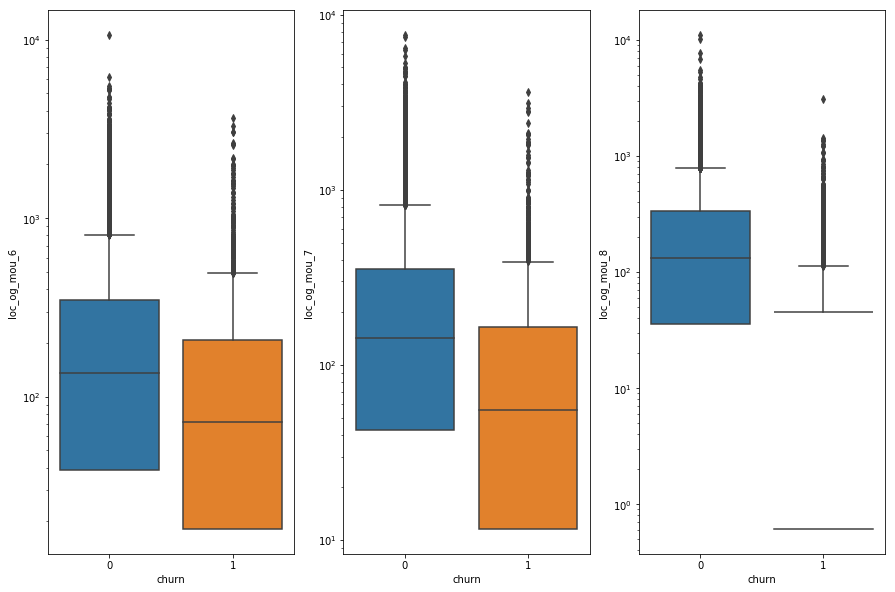

In [66]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='loc_og_mou_6', data=main_frame)
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='loc_og_mou_7', data=main_frame)
plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='loc_og_mou_8', data=main_frame)
plt.yscale('log')


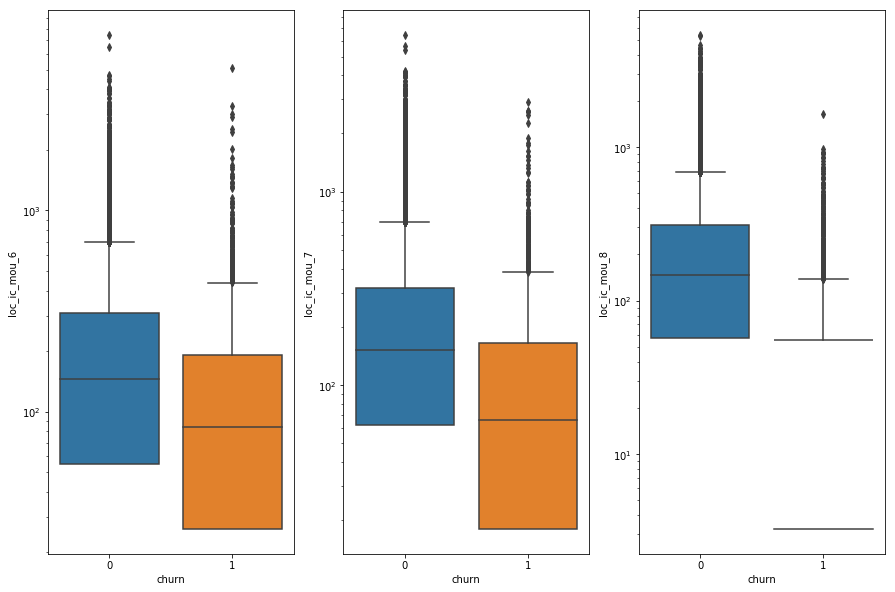

In [67]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='loc_ic_mou_6', data=main_frame)
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='loc_ic_mou_7', data=main_frame)
plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='loc_ic_mou_8', data=main_frame)
plt.yscale('log')


- Analysis of isd_og_mou

In [68]:
main_frame.pivot_table(values= ['isd_og_mou_6','isd_og_mou_7','isd_og_mou_8'],
                      index='churn',
                      aggfunc= 'mean')

,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8
churn,,,
0,1.990468,2.010756,1.995247
1,3.005952,3.142558,1.380418


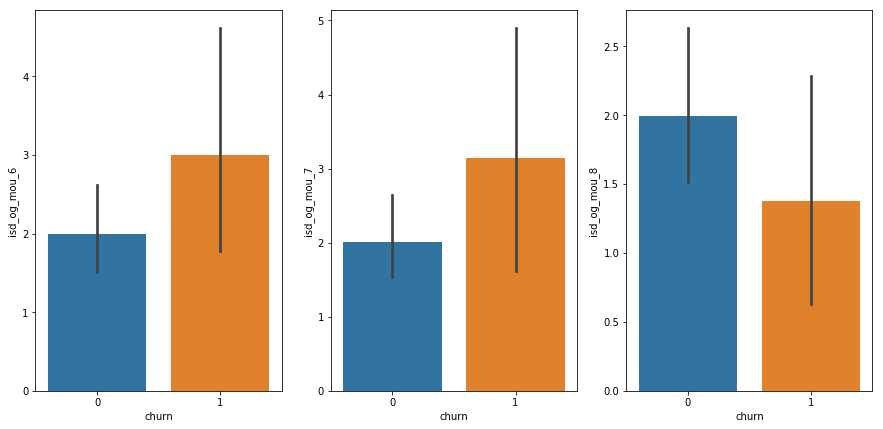

In [69]:
plt.figure(figsize=(15,7))

plt.subplot(1, 3, 1)
sns.barplot(x='churn', y='isd_og_mou_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.barplot(x='churn', y='isd_og_mou_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.barplot(x='churn', y='isd_og_mou_8', data=main_frame)
# plt.yscale('log')


- Analysis of isd_ic_mou

In [70]:
main_frame.pivot_table(values= ['isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8'],
                     index= 'churn',
                      aggfunc= 'mean')

,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8
churn,,,
0,10.812188,12.149638,11.719971
1,12.043211,11.310241,4.475167


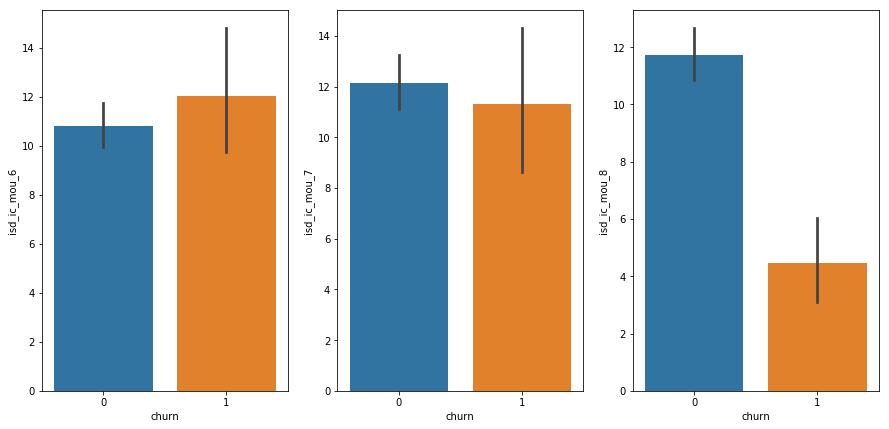

In [71]:
plt.figure(figsize=(15,7))

plt.subplot(1, 3, 1)
sns.barplot(x='churn', y='isd_ic_mou_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.barplot(x='churn', y='isd_ic_mou_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.barplot(x='churn', y='isd_ic_mou_8', data=main_frame)
# plt.yscale('log')


In [72]:
main_frame[['isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8','isd_og_mou_6','isd_og_mou_7','isd_og_mou_8']].describe()

,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8
count,28667.000000,28667.000000,28667.000000,28667.000000,28667.000000,28667.000000
mean,10.894293,12.093653,11.236765,2.058198,2.086244,1.954240
std,77.584766,81.284662,71.653949,45.841883,46.258955,45.484324
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6789.410000,4747.910000,3432.880000,5900.660000,5490.280000,5681.540000


- std_og_mou_6/7/8

In [73]:
main_frame.pivot_table(values=['std_og_mou_6','std_og_mou_7','std_og_mou_8'],
                      index= 'churn',
                      aggfunc= 'mean')

,std_og_mou_6,std_og_mou_7,std_og_mou_8
churn,,,
0,330.769433,358.814272,325.315932
1,678.540617,563.227040,192.508107


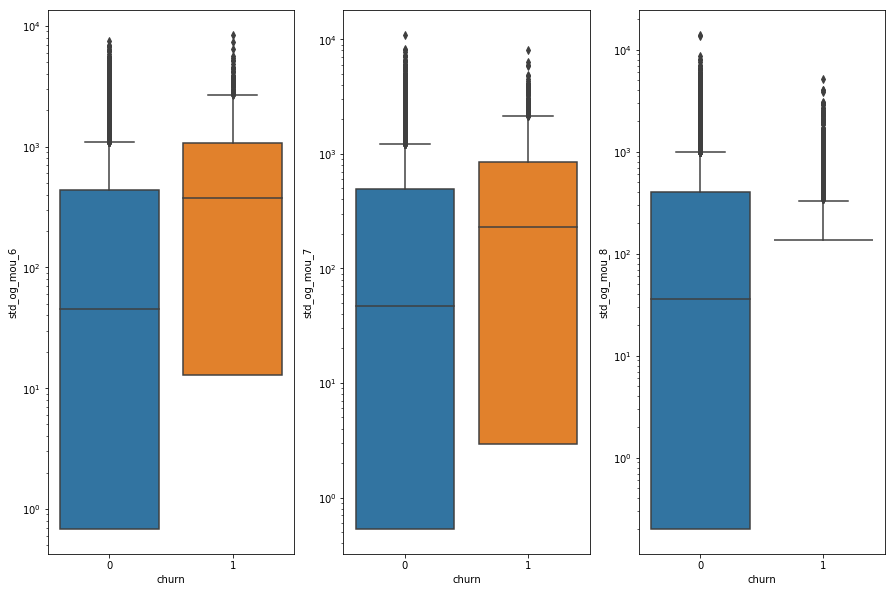

In [74]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='std_og_mou_6', data=main_frame)
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='std_og_mou_7', data=main_frame)
plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='std_og_mou_8', data=main_frame)
plt.yscale('log')


- std_ic_mou_6/7/8

In [75]:
main_frame.pivot_table(values=['std_ic_mou_6','std_ic_mou_7','std_ic_mou_8'],
                      index= 'churn',
                      aggfunc= 'mean')

,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8
churn,,,
0,47.006480,50.450921,47.967067
1,56.542521,49.887552,17.560732


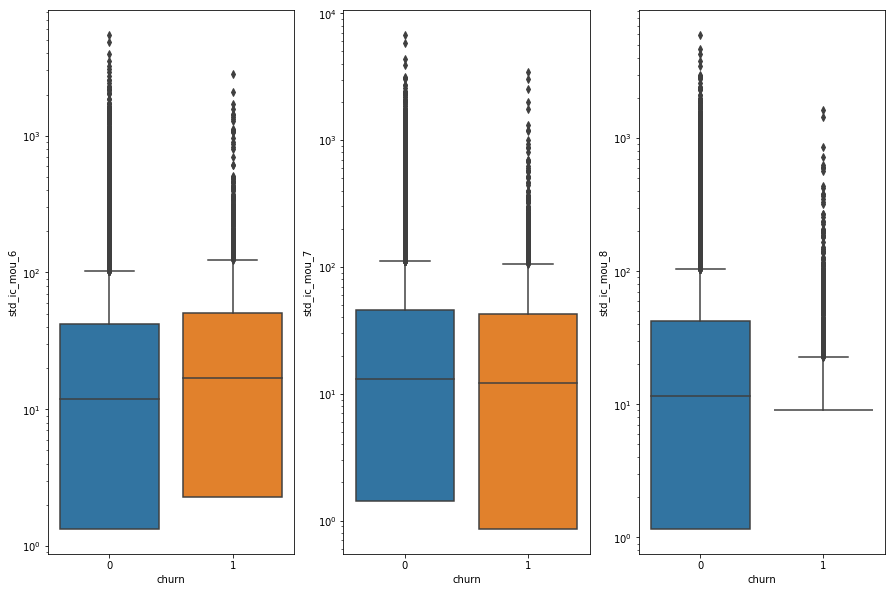

In [76]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='std_ic_mou_6', data=main_frame)
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='std_ic_mou_7', data=main_frame)
plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='std_ic_mou_8', data=main_frame)
plt.yscale('log')


### Analysis of _Average revenue per user_

In [77]:
main_frame.pivot_table(values=['arpu_6','arpu_7','arpu_8'],
                      index= 'churn',
                      aggfunc= 'mean')

,arpu_6,arpu_7,arpu_8
churn,,,
0,555.406836,568.007230,537.867163
1,659.703884,585.006313,274.780581


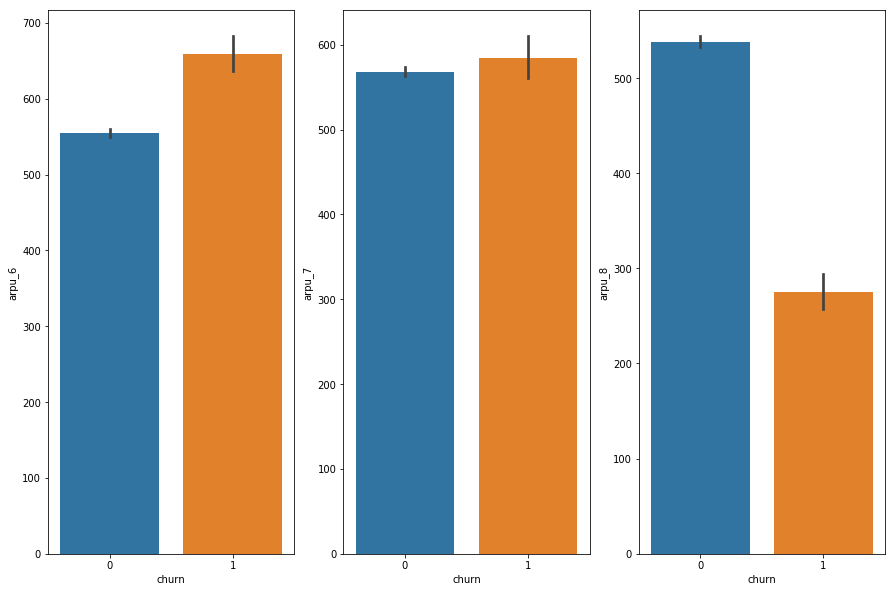

In [78]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.barplot(x='churn', y='arpu_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.barplot(x='churn', y='arpu_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.barplot(x='churn', y='arpu_8', data=main_frame)
# plt.yscale('log')


#### Let's also look at the distribution of day of last recharge

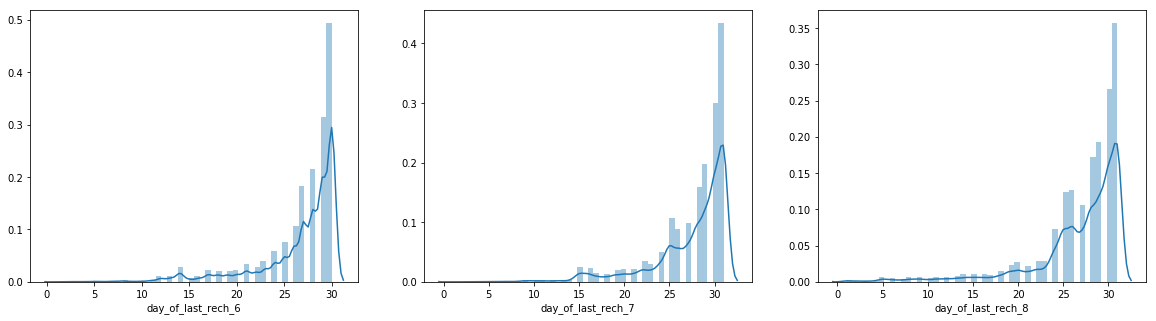

In [79]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.distplot(main_frame['day_of_last_rech_6'])
plt.subplot(1, 3, 2)
sns.distplot(main_frame['day_of_last_rech_7'])
plt.subplot(1, 3, 3)
sns.distplot(main_frame['day_of_last_rech_8'])

In [80]:
main_frame.groupby(['churn','day_of_last_rech_6'])['mobile_number'].count()

churn  day_of_last_rech_6
0      1                        4
       2                        9
       3                       14
       4                       12
       5                       21
       6                       15
       7                       30
       8                       44
       9                       22
       10                      29
       11                      63
       12                     175
       13                     176
       14                     454
       15                     115
       16                     178
       17                     362
       18                     344
       19                     343
       20                     359
       21                     537
       22                     463
       23                     639
       24                     928
       25                    1166
       26                    1656
       27                    2850
       28                    3337
       29             

In [81]:
main_frame.groupby(['churn','day_of_last_rech_7'])['mobile_number'].count()

churn  day_of_last_rech_7
0      1                        3
       2                        1
       3                        9
       4                        9
       5                        4
       6                        9
       7                       15
       8                       12
       9                       48
       10                      39
       11                      35
       12                      39
       13                      44
       14                      53
       15                     391
       16                     371
       17                     226
       18                     214
       19                     311
       20                     357
       21                     339
       22                     563
       23                     482
       24                     826
       25                    1644
       26                    1429
       27                    1578
       28                    2595
       29             

In [82]:
main_frame.groupby(['churn','day_of_last_rech_8'])['mobile_number'].count()

churn  day_of_last_rech_8
0      1                       33
       2                       25
       3                       21
       4                       24
       5                       95
       6                       65
       7                       56
       8                       83
       9                       99
       10                      68
       11                      96
       12                      97
       13                     113
       14                     160
       15                     149
       16                     158
       17                     152
       18                     232
       19                     330
       20                     413
       21                     353
       22                     419
       23                     470
       24                    1116
       25                    1886
       26                    1864
       27                    1764
       28                    2747
       29             

# Model Building


In [83]:
## Seperating independent variables and target variables
X = main_frame.drop(['mobile_number','churn'], axis=1)
y = main_frame[['churn']]

In [84]:
##Creating another copy for logistic regression as it needs scaled data and ree models don't
Xl= copy.copy(X)
yl= copy.copy(y)

In [85]:
print(X.shape)
print(y.shape)

(28667, 147)
(28667, 1)


### Logistic Regression

In [86]:
### standardising the data.
### Since Xl is copy of X we can use it in the following way so that we don't end up losing name of the columns.
Xl= (X-X.mean())/X.std()

For each category (level) of a categorical variable, computing the churn rate (i.e. no. of churn/non-churn + churn), which will be a number (fraction) and replacing each categorical level with this number. 


In [87]:
# computing the churn rate
npu_6 = main_frame.groupby('night_pck_user_6')['churn'].mean()
npu_7 = main_frame.groupby('night_pck_user_7')['churn'].mean()
npu_8 = main_frame.groupby('night_pck_user_8')['churn'].mean()

fbu_6 = main_frame.groupby('fb_user_6')['churn'].mean()
fbu_7 = main_frame.groupby('fb_user_7')['churn'].mean()
fbu_8 = main_frame.groupby('fb_user_8')['churn'].mean()

In [88]:
npu_6

night_pck_user_6
-1.0    0.085606
 0.0    0.051058
 1.0    0.076726
Name: churn, dtype: float64

In [89]:
# creating dictionaries cosnsisting of churn rate for categories
np6= npu_6.to_dict()
np7= npu_7.to_dict()
np8= npu_8.to_dict()

fb6= fbu_6.to_dict()
fb7= fbu_7.to_dict()
fb8= fbu_8.to_dict()

In [90]:
# changing the categorical colummn values by the map created in the dictionaries above
Xl= Xl.replace({"night_pck_user_6": np6})
Xl= Xl.replace({"night_pck_user_7": np7})
Xl= Xl.replace({"night_pck_user_8": np8})
Xl= Xl.replace({"fb_user_6": fb6})
Xl= Xl.replace({"fb_user_7": fb7})
Xl= Xl.replace({"fb_user_8": fb8})

In [91]:
# splitting data into training and tesing sets
Xl_train, Xl_test, yl_train, yl_test= train_test_split(Xl, yl, train_size= 0.7, test_size= 0.3, random_state= 100)

In [92]:
#Percentage churner in training data set
yl_train[yl_train['churn']==1].count()/yl_train['churn'].count() * 100

churn    6.777634
dtype: float64

- In training data set the churning rate is 6.77. This rate is very low and can lead to very high bias.
- To counter this we are going to use oversampling 

In [93]:
## Saving column names as after applying SMOTE() dataframe gets converted to numpy array.
Xl_train_col = Xl_train.columns
yl_train_col = yl_train.columns

In [94]:
# Here we are applying SMOTE and incresing the churn rate to 12.2
Xl_train_res, yl_train_res = SMOTE(0.14).fit_sample(Xl_train, yl_train)

In [95]:
type(Xl_train_res)

numpy.ndarray

In [96]:
# Let's convert this numpy array to pandas dataframe
# Converting numpy arrays Xl_train_res, yl_train_res to pandas dataframe after SMOTE
Xl_train_res = pd.DataFrame(Xl_train_res,columns= Xl_train_col)
yl_train_res = pd.DataFrame(yl_train_res,columns= yl_train_col)


In [97]:
#Percentage churner in training data set
yl_train_res[yl_train_res['churn']==1].count()/yl_train_res['churn'].count() * 100

churn    12.277246
dtype: float64

# PCA

In [98]:
# Find out exactly ho many components explain 85% of variance.
pca = PCA(0.90)

In [99]:
df_train_pca = pca.fit_transform(Xl_train_res)
df_train_pca.shape

(21324, 55)

In [100]:
df_test_pca = pca.transform(Xl_test)
df_test_pca.shape

(8601, 55)

In [101]:
#training the regression model
logreg = LogisticRegression()
logreg_pca = logreg.fit(df_train_pca,yl_train_res)
#Making prediction on the test data
y_pred_probs = logreg_pca.predict_proba(df_test_pca)[:,1]
# AUC-ROC value
"{:2.2f}".format(metrics.roc_auc_score(yl_test, y_pred_probs))

'0.89'

In [102]:
y_pred_pca = logreg_pca.predict(df_test_pca)

In [103]:
print(metrics.confusion_matrix(yl_test, y_pred_pca ))

[[7815  234]
 [ 312  240]]


In [104]:
y_pred_1 = pd.DataFrame(y_pred_probs,columns=['churn_probability'])

y_pred_1.head()


,churn_probability
0,0.021732
1,0.012321
2,0.004518
3,0.020278
4,0.072801


In [105]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(yl_test)
y_test_df.head()

,churn
87716,0
52210,0
70791,0
61624,0
11423,0


In [106]:
# # Putting CustID to index
y_test_df['ID'] = y_test_df.index
# # Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# # Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
# # Rearranging the columns
y_pred_final = y_pred_final.reindex_axis(['ID','churn','churn_probability'], axis=1)
# # Let's see the head of y_pred_final
y_pred_final.head()
# y_test_df.head()


,ID,churn,churn_probability
0,87716,0,0.021732
1,52210,0,0.012321
2,70791,0,0.004518
3,61624,0,0.020278
4,11423,0,0.072801


In [107]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
y_pred_final['predicted'] = y_pred_final.churn_probability.map( lambda x: 1 if x > 0.5 else 0)
# Let's see the head
y_pred_final.head()

,ID,churn,churn_probability,predicted
0,87716,0,0.021732,0
1,52210,0,0.012321,0
2,70791,0,0.004518,0
3,61624,0,0.020278,0
4,11423,0,0.072801,0


In [108]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/100 for x in range(0,51)]
for i in numbers:
    y_pred_final[i]= y_pred_final.churn_probability.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

,ID,churn,churn_probability,predicted,0.0,0.01,0.02,0.03,0.04,0.05,...,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5
0,87716,0,0.021732,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,52210,0,0.012321,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,70791,0,0.004518,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,61624,0,0.020278,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11423,0,0.072801,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


- Finding optimal cutoff point

In [109]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [float(x)/100 for x in range(0,51)]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

      prob  accuracy     sensi     speci
0.00  0.00  0.064179  0.000000  1.000000
0.01  0.01  0.365423  0.324264  0.965580
0.02  0.02  0.476224  0.443658  0.951087
0.03  0.03  0.559702  0.533482  0.942029
0.04  0.04  0.618068  0.596720  0.929348
0.05  0.05  0.657830  0.641073  0.902174
0.06  0.06  0.695733  0.682197  0.893116
0.07  0.07  0.726660  0.716238  0.878623
0.08  0.08  0.751192  0.743322  0.865942
0.09  0.09  0.772120  0.766182  0.858696
0.10  0.10  0.788280  0.784445  0.844203
0.11  0.11  0.803627  0.801963  0.827899
0.12  0.12  0.816649  0.816499  0.818841
0.13  0.13  0.827346  0.828177  0.815217
0.14  0.14  0.838856  0.841098  0.806159
0.15  0.15  0.847343  0.851162  0.791667
0.16  0.16  0.856645  0.861101  0.791667
0.17  0.17  0.864783  0.870046  0.788043
0.18  0.18  0.872689  0.879115  0.778986
0.19  0.19  0.879084  0.887067  0.762681
0.20  0.20  0.883967  0.893279  0.748188
0.21  0.21  0.887687  0.897751  0.740942
0.22  0.22  0.891524  0.902597  0.730072
0.23  0.23  0.89

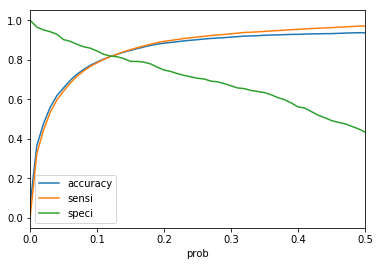

In [110]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

##### From the plot above the optimal cut off probability is 0.11

In [111]:
print(metrics.confusion_matrix( y_pred_final.churn, y_pred_final[0.12] ))

[[6572 1477]
 [ 100  452]]


In [112]:
print(classification_report(y_pred_final.churn,y_pred_final[0.12]))

             precision    recall  f1-score   support

          0       0.99      0.82      0.89      8049
          1       0.23      0.82      0.36       552

avg / total       0.94      0.82      0.86      8601



- This is going to be our final model with cut off probability of 0.12

# Tree models

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.7, test_size= 0.3)

##  Decision Tree

In [114]:
# fit model on training data with default hyperparameters
shallow_tree = DecisionTreeClassifier(max_depth=3, random_state=100)

In [115]:
shallow_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [116]:
# This will predict the the label
y_pred_dt1 = shallow_tree.predict(X_test)

#This will calculate probabilities
y_pred_dt2 = shallow_tree.predict_proba(X_test)

dt_accuracy = metrics.accuracy_score(y_test, y_pred_dt1)
dt_auc= metrics.roc_auc_score(y_test, y_pred_dt2[:,1])
print('This decision tree has accuracy rate of',dt_accuracy,'and ROC-AUC',dt_auc)

This decision tree has accuracy rate of 0.946634112313 and ROC-AUC 0.855254021871


In [117]:
confusion_dt = metrics.confusion_matrix( y_test, y_pred_dt1)
confusion_dt

array([[7898,  118],
       [ 341,  244]])

In [118]:
# Let's check the report of our default model
print(classification_report(y_test,y_pred_dt1))

             precision    recall  f1-score   support

          0       0.96      0.99      0.97      8016
          1       0.67      0.42      0.52       585

avg / total       0.94      0.95      0.94      8601



In [119]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot, graphviz

# Putting features
features = list(X.columns)
len(features)

147

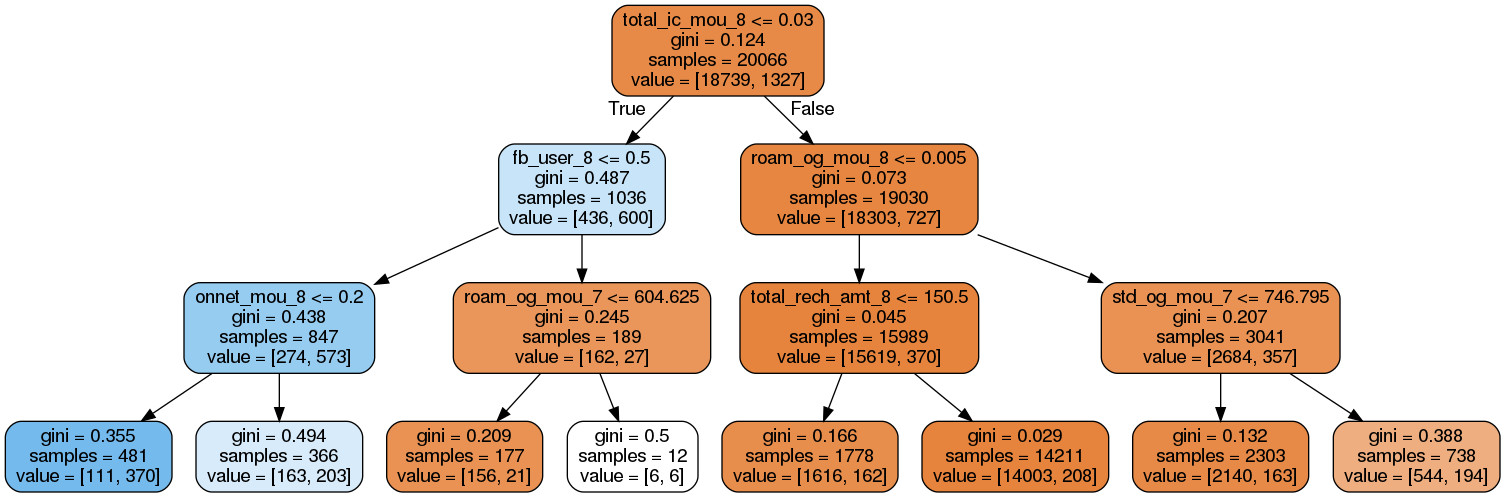

In [120]:
dot_data = StringIO()  
export_graphviz(shallow_tree, out_file=dot_data,
                feature_names=features, filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

## Random Forest

### with default hyper-parameters

In [121]:
rfc1= RandomForestClassifier()

In [122]:
# fit
rfc1.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [123]:
# This will predict the the label
y_pred_rf11 = rfc1.predict(X_test)

#This will calculate probabilities
y_pred_rf12 = rfc1.predict_proba(X_test)

rf1_accuracy = metrics.accuracy_score(y_test, y_pred_rf11)
rf1_auc= metrics.roc_auc_score(y_test, y_pred_rf12[:,1])
print('This decision tree has accuracy rate of',rf1_accuracy,'and ROC-AUC',rf1_auc)

This decision tree has accuracy rate of 0.944773863504 and ROC-AUC 0.846229869321


In [124]:
confusion_rf1 = metrics.confusion_matrix( y_test, y_pred_rf11)
confusion_rf1

array([[7921,   95],
       [ 380,  205]])

In [125]:
# Let's check the report of our default model
print(classification_report(y_test,y_pred_rf11))

             precision    recall  f1-score   support

          0       0.95      0.99      0.97      8016
          1       0.68      0.35      0.46       585

avg / total       0.94      0.94      0.94      8601



### Tuning hyper parameters

In [126]:
rfc2 = RandomForestClassifier(bootstrap=True,
                             max_depth=4,
                             max_features=40,
                             n_estimators=400)
#                              )

In [127]:
# fit
rfc2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=40, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [128]:
# This will predict the the label
y_pred_rf21 = rfc2.predict(X_test)

#This will calculate probabilities
y_pred_rf22 = rfc2.predict_proba(X_test)


rf2_accuracy = metrics.accuracy_score(y_test, y_pred_rf21)
rf2_auc= metrics.roc_auc_score(y_test, y_pred_rf22[:,1])
print('This random forest has accuracy rate of',rf2_accuracy,'and ROC-AUC',rf2_auc)

This random forest has accuracy rate of 0.947564236717 and ROC-AUC 0.917615410205


In [129]:
# Let's see th confusion matrix for this random forest
print(metrics.confusion_matrix( y_test, y_pred_rf21))

[[7915  101]
 [ 350  235]]


In [130]:
# Let's check the report of our default model
print(classification_report(y_test,y_pred_rf21))

             precision    recall  f1-score   support

          0       0.96      0.99      0.97      8016
          1       0.70      0.40      0.51       585

avg / total       0.94      0.95      0.94      8601



## AdaBoost

In [131]:
# adaboost with the shallow_tree as base estimator.
# we're using the same shallow_tree in the very beginning of decision tree model.

estimators = list(range(1, 70, 5))

abc_scores = []
for n_est in estimators:
    ABC = AdaBoostClassifier(
    base_estimator=shallow_tree, 
    n_estimators = n_est)
    
    ABC.fit(X_train, y_train)
    y_pred_ab = ABC.predict_proba(X_test)
    score = metrics.roc_auc_score(y_test, y_pred_ab[:,1])
    abc_scores.append(score)

In [132]:
abc_scores

[0.85525402187078847,
 0.91299804237678495,
 0.90731880256580855,
 0.90684347117730357,
 0.90007485029940126,
 0.89802563676066671,
 0.89642403227732592,
 0.8903688349796135,
 0.88624631079720906,
 0.88371398229182663,
 0.87911058225429495,
 0.87800659365030631,
 0.86996797004282034,
 0.8666257229131481]

In [133]:
max(abc_scores)

0.91299804237678495

In [134]:
[i for i in range (1,70,5)]

[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66]

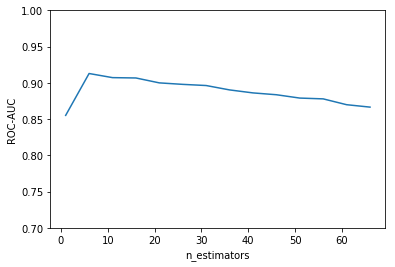

In [135]:
# plot test scores and n_estimators
# plot
plt.plot(estimators, abc_scores)
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC')
plt.ylim([0.7, 1])
plt.show()

- For 11 estimators we are getting maximum ROC-AUC.
- Let's evaluate it further.

In [136]:
abc_final= AdaBoostClassifier(
    base_estimator=shallow_tree, 
    n_estimators = 6)

In [137]:
abc_final.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
          learning_rate=1.0, n_estimators=6, random_state=None)

In [138]:
# This will predict the the label
y_pred_ab1 = abc_final.predict(X_test)

#This will calculate probabilities
y_pred_ab2 = abc_final.predict_proba(X_test)


abc_accuracy = metrics.accuracy_score(y_test, y_pred_ab1)
abc_auc= metrics.roc_auc_score(y_test, y_pred_ab2[:,1])
print('This AdaBoost model gives has accuracy rate of',abc_accuracy,'and ROC-AUC',abc_auc)

This AdaBoost model gives has accuracy rate of 0.945703987908 and ROC-AUC 0.912998042377


In [139]:
print(metrics.confusion_matrix( y_test, y_pred_ab1))


[[7859  157]
 [ 310  275]]


In [140]:
# Let's check the report of our default model
print(classification_report(y_test,y_pred_ab1))

             precision    recall  f1-score   support

          0       0.96      0.98      0.97      8016
          1       0.64      0.47      0.54       585

avg / total       0.94      0.95      0.94      8601



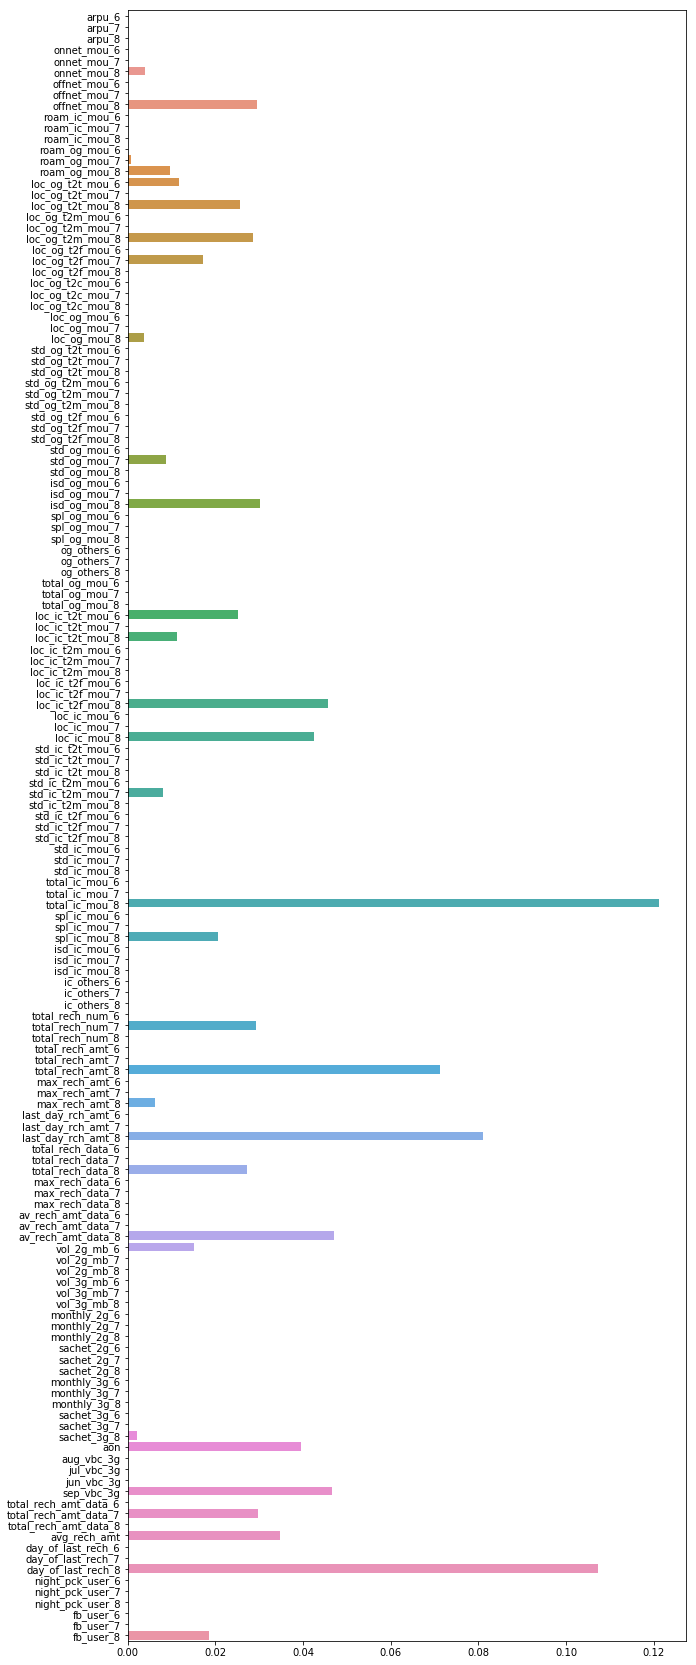

In [141]:
plt.figure(figsize=(10,30))
sns.barplot(x=abc_final.feature_importances_ ,y= X_train.columns)

### XgBoost

#### Running first model(Default hyperparameters)

In [142]:
# fit model on training data with default hyperparameters
model_xg = XGBClassifier()
model_xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [143]:
# make predictions for test data
# use predict_proba since we need probabilities to compute auc
y_pred_xg1 = model_xg.predict(X_test)
y_pred_xg2 = model_xg.predict_proba(X_test)

xg_accuracy = metrics.accuracy_score(y_test, y_pred_xg1)
xg_auc= metrics.roc_auc_score(y_test, y_pred_xg2[:,1])
print('This XGBoost model gives has accuracy rate of',xg_accuracy,'and ROC-AUC',xg_auc)

This XGBoost model gives has accuracy rate of 0.949191954424 and ROC-AUC 0.942165028917


In [144]:
print(metrics.confusion_matrix(y_test, y_pred_xg1))

[[7904  112]
 [ 325  260]]


###  Grid Search to Find Optimal Hyperparameters

In [145]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.4, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=3)

# set up GridSearchCV()
xgb_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      



In [146]:
# fit the model
xgb_cv.fit(X_train, y_train)       

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  4.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.2, 0.4, 0.6], 'subsample': [0.3, 0.6, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [147]:
# cv results
xg_cv_results = pd.DataFrame(xgb_cv.cv_results_)
xg_cv_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,7.610476,0.051249,0.931397,0.978307,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",4,0.925805,0.977828,0.940310,0.976240,0.928078,0.980852,0.537997,0.000539,0.006370,0.001913
1,11.418692,0.057243,0.939638,0.983814,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",2,0.933283,0.984368,0.948290,0.983016,0.937342,0.984058,0.602395,0.009799,0.006338,0.000578
2,12.114402,0.050769,0.942273,0.984941,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",1,0.936827,0.985639,0.949784,0.984526,0.940211,0.984657,0.892899,0.002468,0.005487,0.000496
3,7.587167,0.054627,0.902318,0.985384,0.4,0.3,"{'learning_rate': 0.4, 'subsample': 0.3}",8,0.895423,0.985187,0.912199,0.983577,0.899336,0.987390,0.442207,0.007550,0.007166,0.001563
4,11.247762,0.056885,0.924435,0.993695,0.4,0.6,"{'learning_rate': 0.4, 'subsample': 0.6}",6,0.917817,0.993260,0.932712,0.993582,0.922777,0.994242,0.751160,0.006069,0.006193,0.000409
5,11.775680,0.053300,0.931400,0.996146,0.4,0.9,"{'learning_rate': 0.4, 'subsample': 0.9}",3,0.926993,0.996362,0.941417,0.995517,0.925791,0.996558,0.977834,0.001551,0.007100,0.000452
6,7.653432,0.052326,0.887174,0.982672,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",9,0.892680,0.983160,0.893700,0.981589,0.875140,0.983268,0.037889,0.000704,0.008519,0.000767
7,10.800384,0.052995,0.910193,0.997684,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",7,0.906870,0.997646,0.911035,0.997471,0.912674,0.997935,0.264826,0.002173,0.002443,0.000191
8,10.904240,0.057689,0.924744,0.998997,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",5,0.918824,0.998963,0.931570,0.998752,0.923841,0.999274,0.132578,0.007519,0.005243,0.000214


In [148]:
print('We can get ROC_AUC of',xgb_cv.best_score_,'using',xgb_cv.best_params_)

We can get ROC_AUC of 0.942273289265 using {'learning_rate': 0.2, 'subsample': 0.9}


In [149]:
xg_cv_results['param_learning_rate'] = xg_cv_results['param_learning_rate'].astype('float')


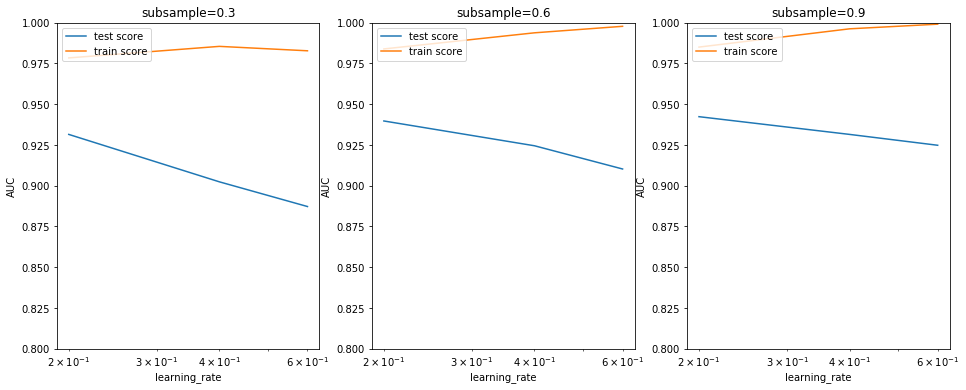

In [150]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.4, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = xg_cv_results[xg_cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.8, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

#### Selecting hyperparameters from above plots as: learning_rate=0.2, subsample=0.6

In [151]:
params = {'learning_rate': 0.2,
          'max_depth': 3, 
          'subsample':0.6,
         'objective':'binary:logistic'}

# fit model on training data
xg_final = XGBClassifier(params = params)
xg_final.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       params={'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.6, 'objective': 'binary:logistic'},
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [152]:
#AUC score
# predict
y_pred_xgb1 = xg_final.predict(X_test)
y_pred_xgb2 = xg_final.predict_proba(X_test)

xg_final_accuracy = metrics.accuracy_score(y_test, y_pred_xgb1)
xg_final_auc = metrics.roc_auc_score(y_test, y_pred_xgb2[:,1])

print('This XGBoost model gives has accuracy rate of',xg_final_accuracy,'and ROC-AUC',xg_final_auc)

This XGBoost model gives has accuracy rate of 0.949191954424 and ROC-AUC 0.942165028917


In [153]:
# Confusion matrix 
print(metrics.confusion_matrix( y_test, y_pred_xgb1))

[[7904  112]
 [ 325  260]]


In [154]:
print(classification_report(y_test, y_pred_xgb1))

             precision    recall  f1-score   support

          0       0.96      0.99      0.97      8016
          1       0.70      0.44      0.54       585

avg / total       0.94      0.95      0.94      8601



In [155]:
importance = dict(zip(X_train.columns, xg_final.feature_importances_))

imp_gain= xg_final.get_booster().get_score(importance_type='gain')
# gain_val = list(imp_gain.values())

imp_weight= xg_final.get_booster().get_score(importance_type='weight')
# weight_val = list(imp_weight.values())

imp_cover= xg_final.get_booster().get_score(importance_type='cover')
# cover_val = list(imp_cover.values())

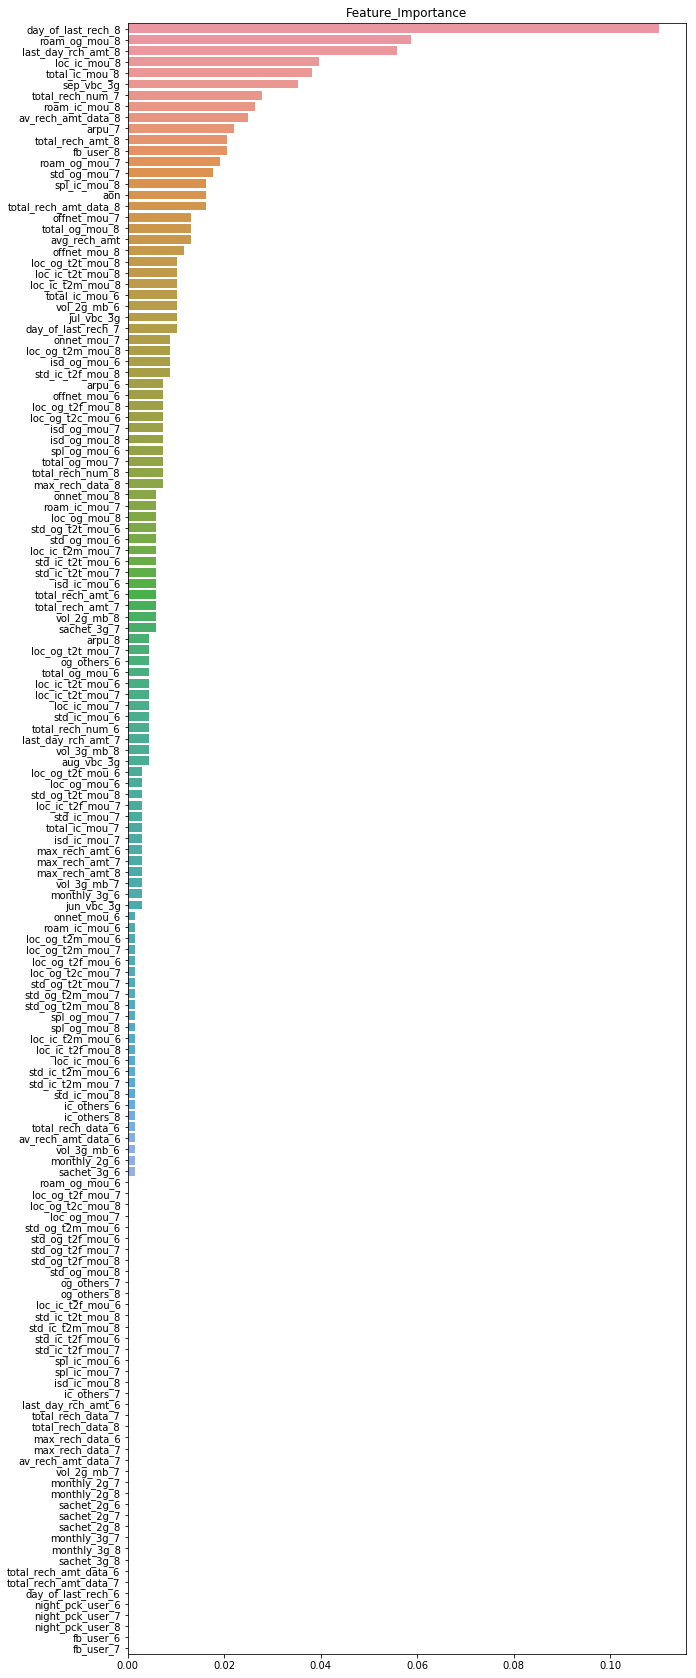

In [156]:
impt_data= sorted(importance.items(), key=lambda x:x[1], reverse=True)
xi_val = [xi[0] for xi in impt_data]
yi_val = [xi[1] for xi in impt_data]
plt.figure(figsize=(10,30))
plt.title('Feature_Importance')
sns.barplot(y= xi_val, x=yi_val)

In [157]:
impt_data[0:10]

[('day_of_last_rech_8', 0.11013216),
 ('roam_og_mou_8', 0.058737151),
 ('last_day_rch_amt_8', 0.055800293),
 ('loc_ic_mou_8', 0.039647575),
 ('total_ic_mou_8', 0.038179148),
 ('sep_vbc_3g', 0.035242289),
 ('total_rech_num_7', 0.027900146),
 ('roam_ic_mou_8', 0.026431719),
 ('av_rech_amt_data_8', 0.024963289),
 ('arpu_7', 0.022026431)]

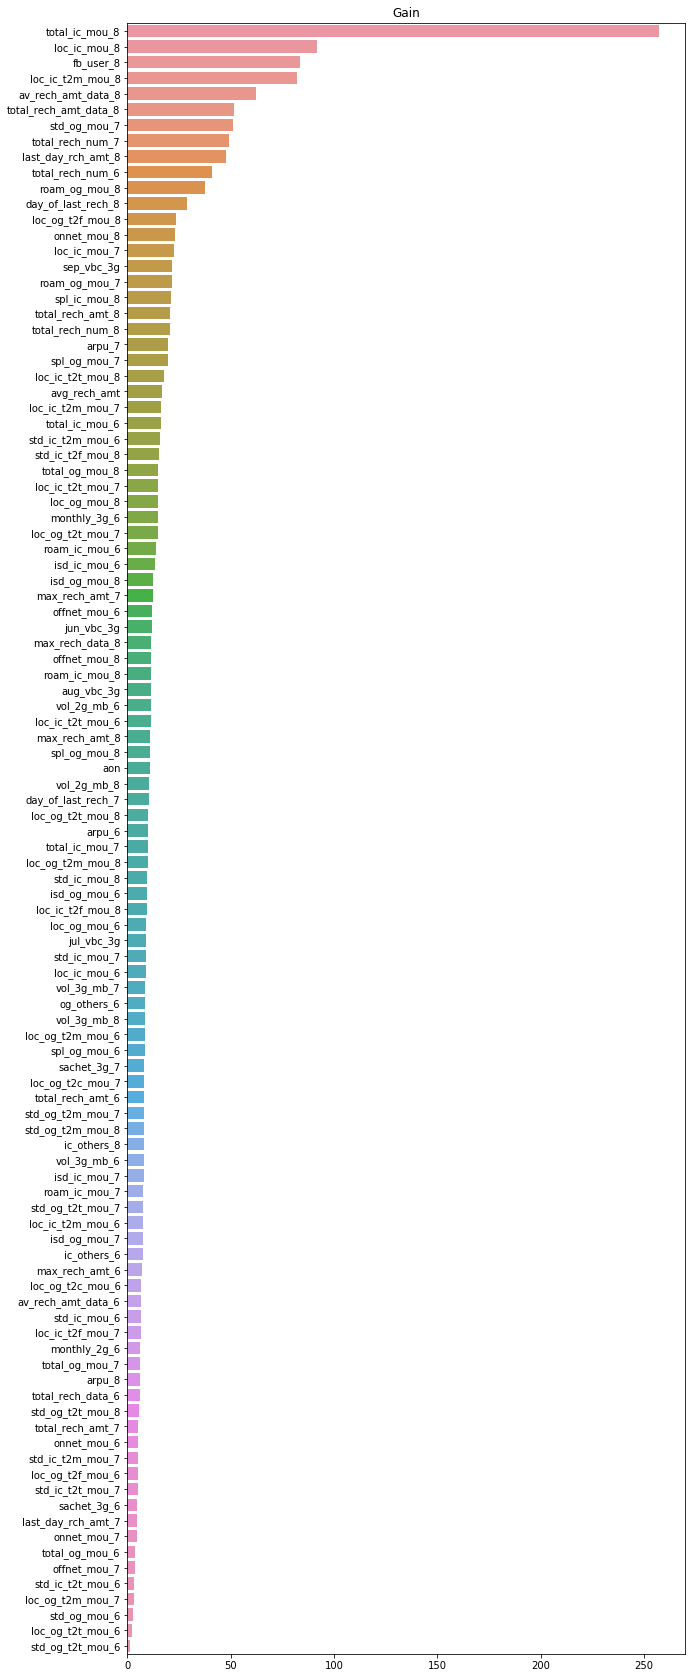

In [158]:
gain_data= sorted(imp_gain.items(), key=lambda x:x[1], reverse=True)
xg_val = [xg[0] for xg in gain_data]
yg_val = [xg[1] for xg in gain_data]
plt.figure(figsize=(10,30))
plt.title('Gain')
# sns.barplot(y= list(imp_gain.keys()),x= gain_val)
sns.barplot(y= xg_val, x=yg_val)

In [159]:
gain_data

[('total_ic_mou_8', 257.2985879930769),
 ('loc_ic_mou_8', 91.62288719259259),
 ('fb_user_8', 83.76976887857143),
 ('loc_ic_t2m_mou_8', 82.00971094142858),
 ('av_rech_amt_data_8', 62.25009322352941),
 ('total_rech_amt_data_8', 51.824085249090906),
 ('std_og_mou_7', 51.23591215833334),
 ('total_rech_num_7', 49.25893482894737),
 ('last_day_rch_amt_8', 47.87254758973685),
 ('total_rech_num_6', 40.85934956666667),
 ('roam_og_mou_8', 37.415385179249995),
 ('day_of_last_rech_8', 28.81954339533333),
 ('loc_og_t2f_mou_8', 23.297074972),
 ('onnet_mou_8', 22.9758631075),
 ('loc_ic_mou_7', 22.620692883333334),
 ('sep_vbc_3g', 21.72926375833333),
 ('roam_og_mou_7', 21.711287203846155),
 ('spl_ic_mou_8', 21.12505306363636),
 ('total_rech_amt_8', 20.570171324857142),
 ('total_rech_num_8', 20.39539224),
 ('arpu_7', 19.82044198533334),
 ('spl_og_mou_7', 19.6602917),
 ('loc_ic_t2t_mou_8', 17.853133612857146),
 ('avg_rech_amt', 16.795215447777778),
 ('loc_ic_t2m_mou_7', 16.33364367),
 ('total_ic_mou_6', 

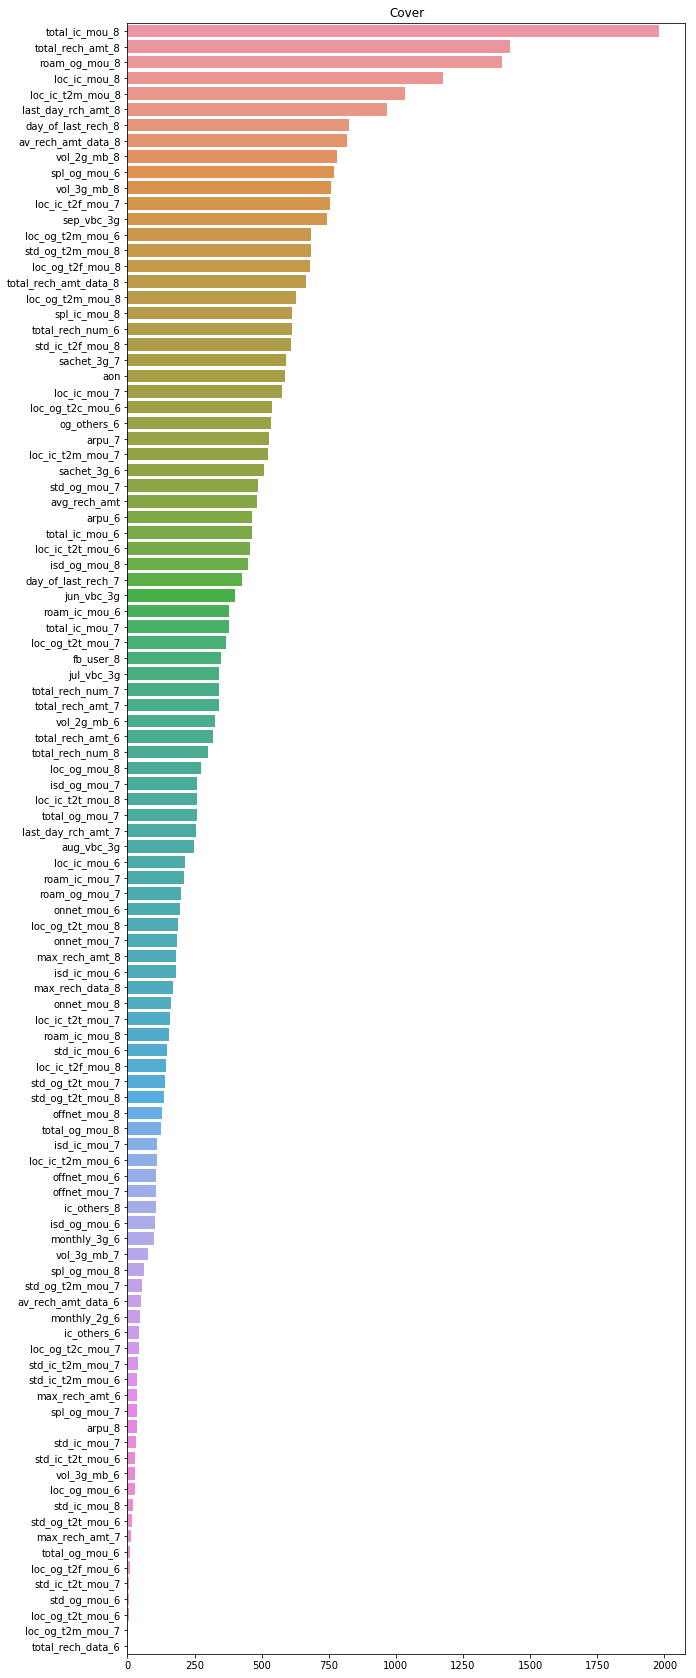

In [160]:
cover_data= sorted(imp_cover.items(), key=lambda x:x[1], reverse=True)
xc_val = [xc[0] for xc in cover_data]
yc_val = [xc[1] for xc in cover_data]
plt.figure(figsize=(10,30))
plt.title('Cover')
# sns.barplot(y= list(imp_cover.keys()),x= weight_val)
sns.barplot(y= xc_val, x=yc_val)

# Report

- __Our predictive model with PCA and logistic regression managed to find churners correctly 82 percent of the time while maintaining overall model accuracy at 81.61 percent at cut-off probability of 0.12.__

- To identify important driving factors, we trained various tree models and among those we are choosing XgBoost and it has necessary metrics associated with it to give clear insight.

#### Feature Importance:
__model.feature_importances__ tells us importance of a feature in generating the prediction. Higher the value more important is the feature in determining the prediction.(in our case which customer is going to churn). When we implemented this on our xg_final model we got following top 10 important features:
- 'day_of_last_rech_8', 'roam_og_mou_8', 'last_day_rch_amt_8', 'total_ic_mou_8', 'sep_vbc_3g', 'av_rech_amt_data_8', 'loc_ic_mou_8', 'aon', 'avg_rech', 'roam_og_mou_7'.

__model gain__ The Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.
- 'total_ic_mou_8', 'loc_ic_mou_8', 'fb_user_8', 'av_rech_amt_data_8', 'total_rech_amt_data_8', 'last_day_rch_amt_8', 'std_og_mou_7', 'roam_og_mou_8', 'loc_og_t2f_mou_8', 'total_rech_num_7'.


## Observations and inferences:
- 6th and 7th month are good phase and 8th month is action phase

- If a customer shows reduction in total incoming calls minutes of usage(total_ic_mou_8) and local incoming calls minutes of usage(loc_ic_mou_8) in action phase to 0 or less than average value of good months, then he/she is most likely to churn in churn phase.
##### Therefore if we want to reduce the churn rate then it's very important to target customers for whome total incoming minutes of usge and local incoming minutes of usage is 0 or less than average of good phase(average: (total_ic_mou_6+total_ic_mou_7)/2 ) in action phase that is 8th  month.

- Also the customers who are going to churn show significant reduction in _average recharge amount data_ in action phase compare to customers who have not churned in action phase. 
##### Therefore from EDA section, customers who show less  average  recharge amount data in action phase(av_rech_amt_data_8) compare to 6th and 7th month should be targeted for less churning rate.

- Last day recharge amount of action phase (last_day_rch_amt_8) is also a important indicator. Interestingly customers who are going to churn show 0 or less than average last day recharge amount not only for 8th month but also for 7th month.(plot from EDA section).
##### Therefore to target customers based on last_day_rch_amt_, we can  look at both last_day_rch_amt_7 and last_day_rch_amt_8 as most of those who are going to churn later show similar behaviour  on the last day recharge amount of 7th and 8th month.

- From the barplot in EDA, customers who are going to churn show small reduction in total recharge amount data 7 compare total recharge amount data 7 but huge fall from total recharge amount data 7 to total recharge amount data 8.

###### From the groupby tables in EDA section, customers for whome last day of recharge has shifted to the first week are very likely to churn. As we can see in the customers with label 1 are less in the the first week of 6th and 7th month but are relatively large in 8th month.


###### Customers who are going to churn also show significant drop in std outgoing minutes of usage in 8th month compare to 6th and 7th month 